# IMPORT DATA

In [1]:
import pandas as pd
import yfinance as yf

BDD_FILE = "Bdd_Projet_Python.xlsx"
START = "2010-01-01"
END   = "2025-01-01"

bdd = pd.read_excel(BDD_FILE).iloc[:, :3]
bdd.columns = ["Ticker", "Industry", "Sector"]

bdd["Ticker"] = bdd["Ticker"].astype(str).str.strip().str.replace(".", "-", regex=False)
bdd["Industry"] = bdd["Industry"].astype(str).str.strip()
bdd["Sector"] = bdd["Sector"].astype(str).str.strip()

bdd = bdd.dropna(subset=["Ticker"])
bdd = bdd[bdd["Ticker"] != ""].drop_duplicates(subset=["Ticker"])

tickers = bdd["Ticker"].tolist()
print("Tickers :", len(tickers), "| Exemples :", tickers[:10])

data = yf.download(tickers, start=START, end=END, auto_adjust=True, threads=True)
close_prices = data.xs("Close", level=0, axis=1)

print("Avant nettoyage :", close_prices.shape)
close_prices = close_prices.dropna(axis=1, thresh=200)
print("Après nettoyage :", close_prices.shape)

# Base propre alignée avec les prix
bdd_clean = bdd[bdd["Ticker"].isin(close_prices.columns)].copy()

print("BDD clean :", len(bdd_clean))
print("Nb industries :", bdd_clean["Industry"].nunique())
print("Nb sectors :", bdd_clean["Sector"].nunique())


/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/1403291703.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Tickers : 503 | Exemples : ['NVDA', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'AVGO', 'META', 'TSLA', 'BRK-B']


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['Q', 'SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1735707600")')


Avant nettoyage : (3774, 503)
Après nettoyage : (3774, 499)
BDD clean : 499
Nb industries : 112
Nb sectors : 12


In [2]:
import pandas as pd
import numpy as np

#construction des indices industry/sector (en equal weight)
daily_returns = close_prices.pct_change()

# on met en base 1 à chaque fois

# industry

map_ind = bdd_clean.set_index("Ticker")["Industry"]
ind_returns = daily_returns.rename(columns=map_ind).groupby(axis=1, level=0).mean()
ind_index = (1 + ind_returns).cumprod()
ind_index.iloc[0] = 1

print("Nb industries :", ind_returns.shape[1])
print("Exemples industries :", ind_returns.columns[:10].tolist())


# secteur

map_sec = bdd_clean.set_index("Ticker")["Sector"]
sec_returns = daily_returns.rename(columns=map_sec).groupby(axis=1, level=0).mean()
sec_index = (1 + sec_returns).cumprod()
sec_index.iloc[0] = 1

print("Nb sectors :", sec_returns.shape[1])
print("Sectors :", sec_returns.columns.tolist())
print(ind_index.tail())
print(sec_index.tail())


Nb industries : 112
Exemples industries : ['Advertising Agencies', 'Aerospace & Defense', 'Agricultural Inputs', 'Airlines', 'Apparel Manufacturing', 'Apparel Retail', 'Asset Management', 'Auto Manufacturers', 'Auto Parts', 'Banks - Diversified']
Nb sectors : 12
Sectors : ['Basic Materials', 'Communication Services', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities', 'nan']
Ticker      Advertising Agencies  Aerospace & Defense  Agricultural Inputs  \
Date                                                                         
2024-12-24             33.583927            14.924050             2.476184   
2024-12-26             33.833703            14.940552             2.466008   
2024-12-27             33.188582            14.849374             2.452836   
2024-12-30             32.951665            14.672873             2.440629   
2024-12-31             32.576282            14.654008       

/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/1857880810.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  ind_returns = daily_returns.rename(columns=map_ind).groupby(axis=1, level=0).mean()
/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/1857880810.py:23: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sec_returns = daily_returns.rename(columns=map_sec).groupby(axis=1, level=0).mean()


In [3]:
import yfinance as yf
import pandas as pd

# Téléchargement benchmark S&P500
bench = yf.download("^GSPC",
                    start=close_prices.index[0],
                    end=close_prices.index[-1],
                    auto_adjust=True)

bench_close = bench["Close"]

# On aligne les dates sur nos indices (industry/sector)
bench_close = bench_close.reindex(close_prices.index).ffill()

# En base 1 également
bench_curve = bench_close / bench_close.iloc[0]

print("Benchmark OK | Nb points :", len(bench_curve))
print(bench_curve.head())


[*********************100%***********************]  1 of 1 completed

Benchmark OK | Nb points : 3774
Ticker         ^GSPC
Date                
2010-01-04  1.000000
2010-01-05  1.003116
2010-01-06  1.003663
2010-01-07  1.007679
2010-01-08  1.010583


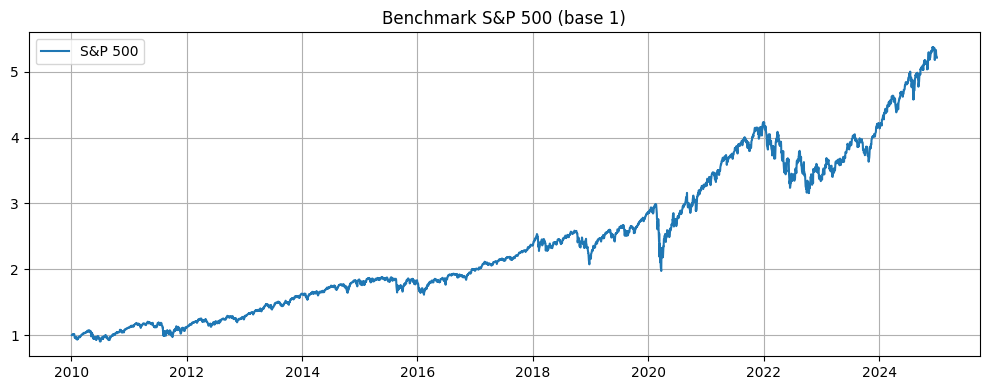

In [4]:
import matplotlib.pyplot as plt

#plot du S&P500

plt.figure(figsize=(10,4))
plt.plot(bench_curve, label="S&P 500")
plt.title("Benchmark S&P 500 (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return index_df.shift(skip).pct_change(periods=W - skip)
/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return index_df.shift(skip).pct_change(periods=W - skip)
/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-

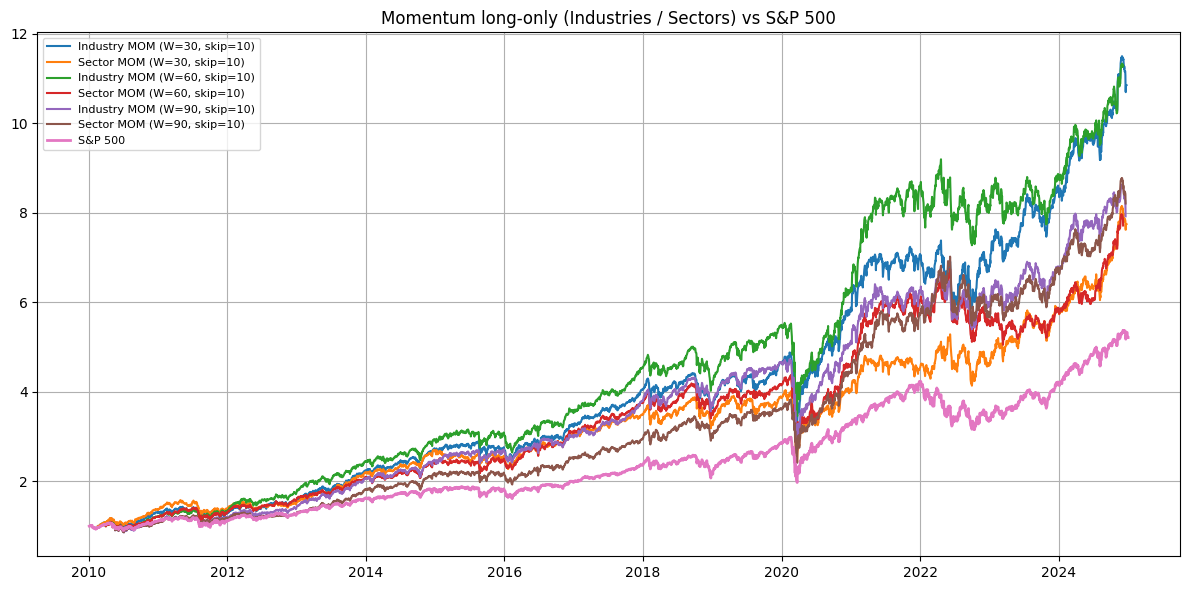

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# paramètres
# on teste 3 fenêtres du momentum
W_list = [30, 60, 90]
skip = 10
reb_step = 21
quantile = 0.30


# 1) signal momentum avec skip

def momentum_with_skip(index_df, W, skip=0):
    # Momentum(t) = perf entre t-W et t-skip (on exclut les derniers jours)
    if skip > 0:
        return index_df.shift(skip).pct_change(periods=W - skip)
    else:
        return index_df.pct_change(periods=W)


# 2) backtest long-only -> long short en fin de code (ne fonctionne pas)

def build_long_list(score_row, q):
    s = score_row.dropna()
    if len(s) == 0:
        return []
    n = max(1, int(len(s) * q))
    return s.sort_values(ascending=False).head(n).index.tolist()

def backtest_long_only(score_df, returns_df, q=0.3, reb_step=21):
    rebalance_dates = score_df.dropna(how="all").index[::reb_step]

    long_hist = []
    daily_list = []

    for d in rebalance_dates:
        long_hist.append(build_long_list(score_df.loc[d], q))

    for i in range(len(rebalance_dates) - 1):
        ds = rebalance_dates[i]
        de = rebalance_dates[i + 1]
        longs = long_hist[i]
        if len(longs) == 0:
            continue

        mask = (returns_df.index > ds) & (returns_df.index <= de)
        period = returns_df.loc[mask, longs]
        if period.empty:
            continue

        daily_list.append(period.mean(axis=1))

    daily = pd.concat(daily_list).sort_index()
    curve = (1 + daily).cumprod()
    curve.iloc[0] = 1.0

    return curve, daily, rebalance_dates, long_hist


# 3) run momentum pour industry & sector

mom_curves = {}   

for W in W_list:
    # Industry
    ind_mom = momentum_with_skip(ind_index, W=W, skip=skip)
    curve_ind, daily_ind, _, _ = backtest_long_only(ind_mom, ind_returns, q=quantile, reb_step=reb_step)
    mom_curves[f"Industry MOM (W={W}, skip={skip})"] = curve_ind

    # Sector
    sec_mom = momentum_with_skip(sec_index, W=W, skip=skip)
    curve_sec, daily_sec, _, _ = backtest_long_only(sec_mom, sec_returns, q=quantile, reb_step=reb_step)
    mom_curves[f"Sector MOM (W={W}, skip={skip})"] = curve_sec


# 4) plot vs benchmark

plt.figure(figsize=(12,6))
for name, curve in mom_curves.items():
    plt.plot(curve, label=name)

plt.plot(bench_curve, label="S&P 500", linewidth=2)
plt.title("Momentum long-only (Industries / Sectors) vs S&P 500")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [6]:

# statistiques de performance

def perf_stats(curve, periods_per_year=252):

    # force curve en Series
    if isinstance(curve, pd.DataFrame):
        curve = curve.iloc[:, 0]
    curve = curve.dropna()

    r = curve.pct_change().dropna()

    ann_return = (curve.iloc[-1] / curve.iloc[0])**(periods_per_year / len(r)) - 1
    ann_vol = float(r.std() * np.sqrt(periods_per_year))

    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    cummax = curve.cummax()
    drawdown = curve / cummax - 1
    max_dd = float(drawdown.min())

    return ann_return, ann_vol, sharpe, max_dd


if isinstance(bench_curve, pd.DataFrame):
    bench_curve = bench_curve.iloc[:, 0]

rows = []

# momentum curves
for name, curve in mom_curves.items():
    ar, vol, sh, dd = perf_stats(curve)
    rows.append([name, ar, vol, sh, dd])

# benchmark
ar, vol, sh, dd = perf_stats(bench_curve)
rows.append(["S&P 500", ar, vol, sh, dd])

stats_df = pd.DataFrame(rows, columns=["Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD"])
stats_df = stats_df.set_index("Strategy").sort_values("Sharpe", ascending=False)

display(stats_df)

,Ann.Return,Ann.Vol,Sharpe,MaxDD
Strategy,,,,
"Industry MOM (W=60, skip=10)",0.179716,0.183749,0.978051,-0.375823
"Industry MOM (W=30, skip=10)",0.174461,0.183730,0.949553,-0.354483
"Sector MOM (W=90, skip=10)",0.155371,0.183827,0.845199,-0.369645
"Industry MOM (W=90, skip=10)",0.152560,0.182403,0.836387,-0.417781
"Sector MOM (W=60, skip=10)",0.149562,0.187496,0.797683,-0.383074
"Sector MOM (W=30, skip=10)",0.148083,0.185755,0.797193,-0.396741
S&P 500,0.116600,0.172330,0.676613,-0.339250


# STRAT

$$
\text{Score}(s,t)
= \text{MOM}_{W}(s,t) \times \max\bigl(H(s,t) - 0.5,\; 0\bigr)
$$

In [7]:
import numpy as np
import pandas as pd

def hurst_rs(series):
    x = np.log(series.dropna().values)
    N = len(x)
    if N < 50:
        return np.nan
    y = x - np.mean(x)
    z = np.cumsum(y)
    R = np.max(z) - np.min(z)
    S = np.std(x, ddof=1)
    if S == 0:
        return np.nan
    return np.log(R / S) / np.log(N)

# fenêtre hurst
H_window = 252

# Hurst sur indices (Industry / Sector)
hurst_ind = ind_index.rolling(H_window).apply(hurst_rs, raw=False)
hurst_sec = sec_index.rolling(H_window).apply(hurst_rs, raw=False)


In [8]:
hurst_curves = {}

for W in W_list:
    # Industry
    ind_mom = momentum_with_skip(ind_index, W=W, skip=skip)
    ind_hadj = (hurst_ind - 0.5).clip(lower=0)
    ind_score = ind_mom * ind_hadj

    curve_ind_h, daily_ind_h, _, _ = backtest_long_only(ind_score, ind_returns, q=quantile, reb_step=reb_step)
    hurst_curves[f"Industry MOMxH (W={W}, skip={skip})"] = curve_ind_h

    # Sector
    sec_mom = momentum_with_skip(sec_index, W=W, skip=skip)
    sec_hadj = (hurst_sec - 0.5).clip(lower=0)
    sec_score = sec_mom * sec_hadj

    curve_sec_h, daily_sec_h, _, _ = backtest_long_only(sec_score, sec_returns, q=quantile, reb_step=reb_step)
    hurst_curves[f"Sector MOMxH (W={W}, skip={skip})"] = curve_sec_h


/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return index_df.shift(skip).pct_change(periods=W - skip)
/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return index_df.shift(skip).pct_change(periods=W - skip)
/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/730458028.py:18: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-

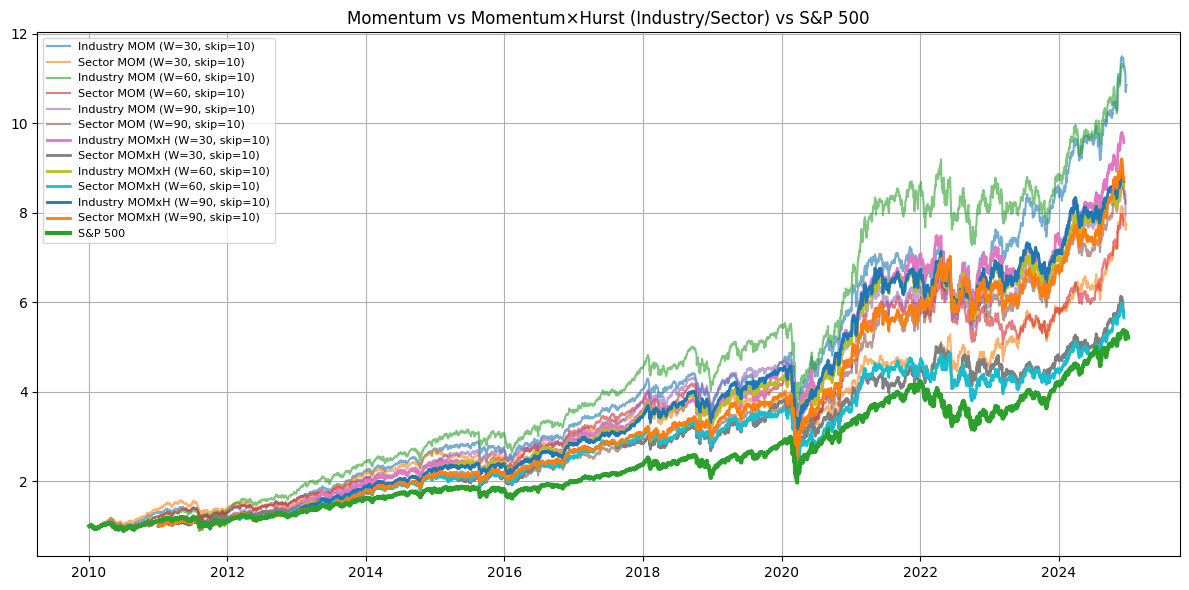

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# momentum
for name, curve in mom_curves.items():
    plt.plot(curve, label=name, alpha=0.6)

# hurst
for name, curve in hurst_curves.items():
    plt.plot(curve, label=name, linewidth=2)

plt.plot(bench_curve, label="S&P 500", linewidth=3)
plt.title("Momentum vs Momentum×Hurst (Industry/Sector) vs S&P 500")
plt.grid(True)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [10]:
rows = []

# momentum
for name, curve in mom_curves.items():
    ar, vol, sh, dd = perf_stats(curve)
    rows.append([name, ar, vol, sh, dd])

# hurst
for name, curve in hurst_curves.items():
    ar, vol, sh, dd = perf_stats(curve)
    rows.append([name, ar, vol, sh, dd])

# benchmark
ar, vol, sh, dd = perf_stats(bench_curve)
rows.append(["S&P 500", ar, vol, sh, dd])

stats_df2 = pd.DataFrame(rows, columns=["Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD"])
stats_df2 = stats_df2.set_index("Strategy").sort_values("Sharpe", ascending=False)

display(stats_df2)


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Strategy,,,,
"Industry MOM (W=60, skip=10)",0.179716,0.183749,0.978051,-0.375823
"Industry MOMxH (W=30, skip=10)",0.176260,0.181249,0.972472,-0.348282
"Industry MOM (W=30, skip=10)",0.174461,0.183730,0.949553,-0.354483
"Industry MOMxH (W=60, skip=10)",0.167255,0.179342,0.932602,-0.349396
"Industry MOMxH (W=90, skip=10)",0.168308,0.180982,0.929970,-0.385203
"Sector MOMxH (W=90, skip=10)",0.168531,0.184005,0.915902,-0.377283
"Sector MOM (W=90, skip=10)",0.155371,0.183827,0.845199,-0.369645
"Industry MOM (W=90, skip=10)",0.152560,0.182403,0.836387,-0.417781
"Sector MOM (W=60, skip=10)",0.149562,0.187496,0.797683,-0.383074


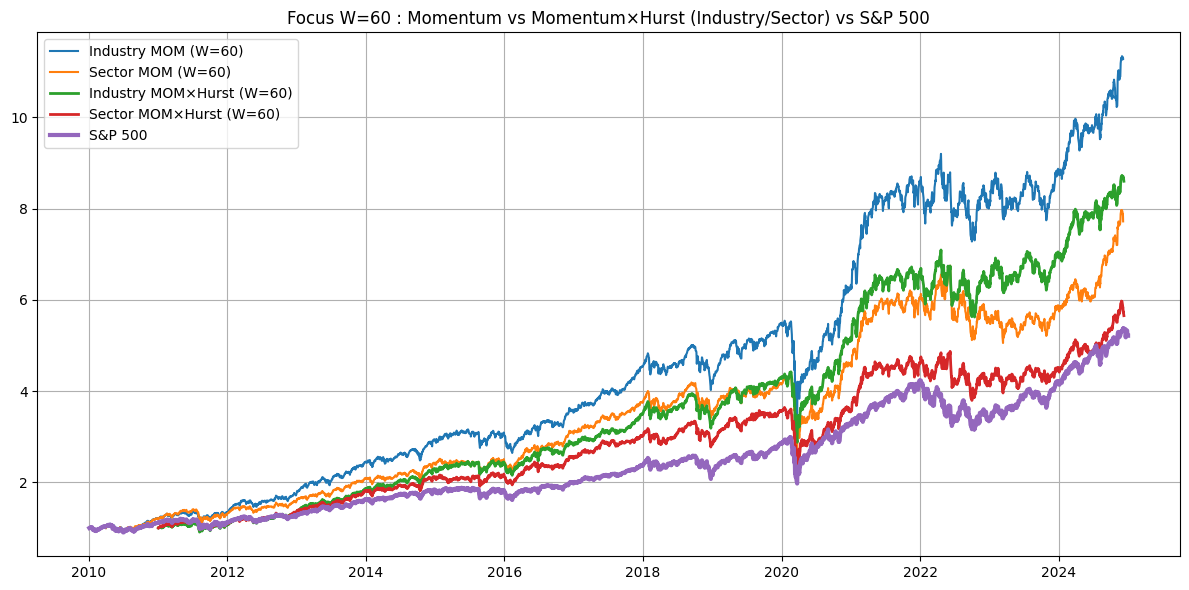

In [11]:
import matplotlib.pyplot as plt

# on se focus sur le cas W=60 car on a vu que c'est celui qui focntionne le mieux et c'est cohérent avec la littérature
W_focus = 60

plt.figure(figsize=(12,6))

# Momentum Industry & Sector (W=60)
plt.plot(mom_curves[f"Industry MOM (W={W_focus}, skip={skip})"], label="Industry MOM (W=60)")
plt.plot(mom_curves[f"Sector MOM (W={W_focus}, skip={skip})"], label="Sector MOM (W=60)")

# Momentum×Hurst Industry & Sector (W=60)
plt.plot(hurst_curves[f"Industry MOMxH (W={W_focus}, skip={skip})"], label="Industry MOM×Hurst (W=60)", linewidth=2)
plt.plot(hurst_curves[f"Sector MOMxH (W={W_focus}, skip={skip})"], label="Sector MOM×Hurst (W=60)", linewidth=2)

# Benchmark
plt.plot(bench_curve, label="S&P 500", linewidth=3)

plt.title("Focus W=60 : Momentum vs Momentum×Hurst (Industry/Sector) vs S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
stats_focus = stats_df2.loc[
    [
        f"Industry MOM (W=60, skip={skip})",
        f"Industry MOMxH (W=60, skip={skip})",
        f"Sector MOM (W=60, skip={skip})",
        f"Sector MOMxH (W=60, skip={skip})",
        "S&P 500"
    ]
]
display(stats_focus)


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Strategy,,,,
"Industry MOM (W=60, skip=10)",0.179716,0.183749,0.978051,-0.375823
"Industry MOMxH (W=60, skip=10)",0.167255,0.179342,0.932602,-0.349396
"Sector MOM (W=60, skip=10)",0.149562,0.187496,0.797683,-0.383074
"Sector MOMxH (W=60, skip=10)",0.132595,0.183879,0.721099,-0.390983
S&P 500,0.116600,0.172330,0.676613,-0.339250


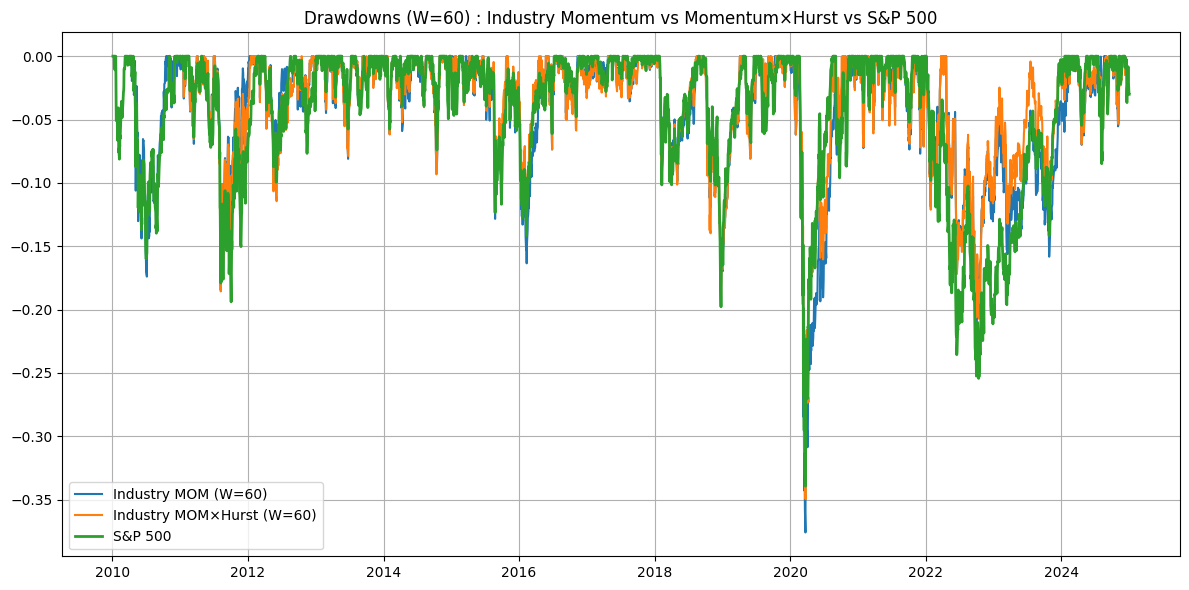

In [13]:
import matplotlib.pyplot as plt
import pandas as pd


# on trace les drawdown

def drawdown(curve):
    curve = curve.dropna()
    peak = curve.cummax()
    dd = curve / peak - 1
    return dd

W_focus = 60

curve_ind_mom = mom_curves[f"Industry MOM (W={W_focus}, skip={skip})"]
curve_ind_h   = hurst_curves[f"Industry MOMxH (W={W_focus}, skip={skip})"]
curve_sp      = bench_curve

dd_ind_mom = drawdown(curve_ind_mom)
dd_ind_h   = drawdown(curve_ind_h)
dd_sp      = drawdown(curve_sp)

plt.figure(figsize=(12,6))
plt.plot(dd_ind_mom, label="Industry MOM (W=60)")
plt.plot(dd_ind_h, label="Industry MOM×Hurst (W=60)")
plt.plot(dd_sp, label="S&P 500", linewidth=2)

plt.title("Drawdowns (W=60) : Industry Momentum vs Momentum×Hurst vs S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
rows = []

# stratégies
curve_ind_mom = mom_curves[f"Industry MOM (W=60, skip={skip})"]
curve_ind_h   = hurst_curves[f"Industry MOMxH (W=60, skip={skip})"]
curve_sp      = bench_curve

for name, curve in [
    ("Industry Momentum (W=60)", curve_ind_mom),
    ("Industry Momentum × Hurst (W=60)", curve_ind_h),
    ("S&P 500", curve_sp),
]:
    ar, vol, sh, dd = perf_stats(curve)
    rows.append([name, ar, vol, sh, dd])

stats_w60 = pd.DataFrame(rows, columns=["Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD"])
stats_w60 = stats_w60.set_index("Strategy")

display(stats_w60)


,Ann.Return,Ann.Vol,Sharpe,MaxDD
Strategy,,,,
Industry Momentum (W=60),0.179716,0.183749,0.978051,-0.375823
Industry Momentum × Hurst (W=60),0.167255,0.179342,0.932602,-0.349396
S&P 500,0.116600,0.172330,0.676613,-0.339250


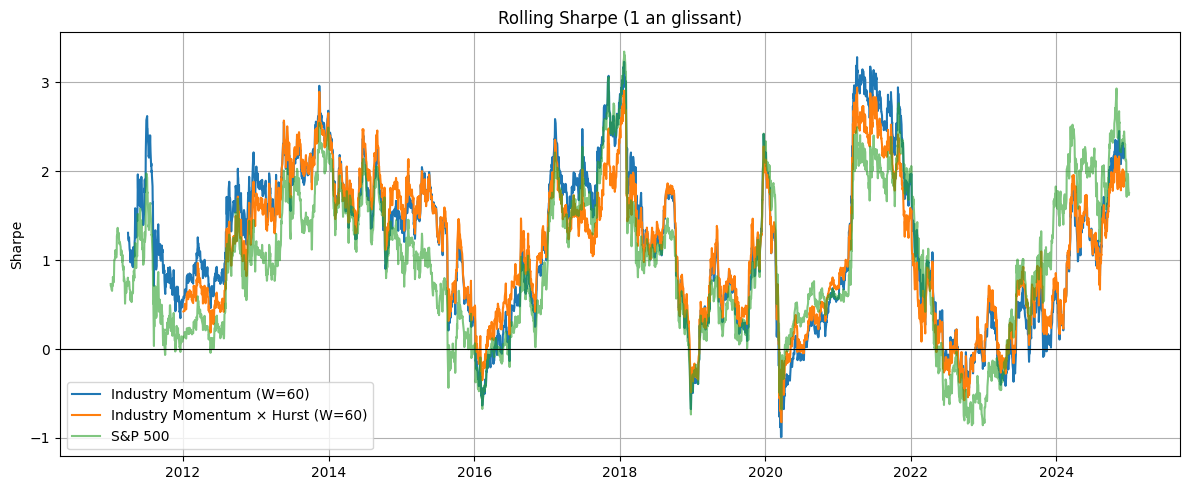

In [15]:
def rolling_sharpe(curve, window=252, periods_per_year=252):
    r = curve.pct_change()
    roll_mean = r.rolling(window).mean() * periods_per_year
    roll_vol = r.rolling(window).std() * np.sqrt(periods_per_year)
    return roll_mean / roll_vol

rs_mom = rolling_sharpe(curve_ind_mom, window=252)
rs_h   = rolling_sharpe(curve_ind_h, window=252)
rs_sp  = rolling_sharpe(bench_curve, window=252)

plt.figure(figsize=(12,5))
plt.plot(rs_mom, label="Industry Momentum (W=60)")
plt.plot(rs_h, label="Industry Momentum × Hurst (W=60)")
plt.plot(rs_sp, label="S&P 500", alpha=0.6)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Rolling Sharpe (1 an glissant)")
plt.ylabel("Sharpe")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


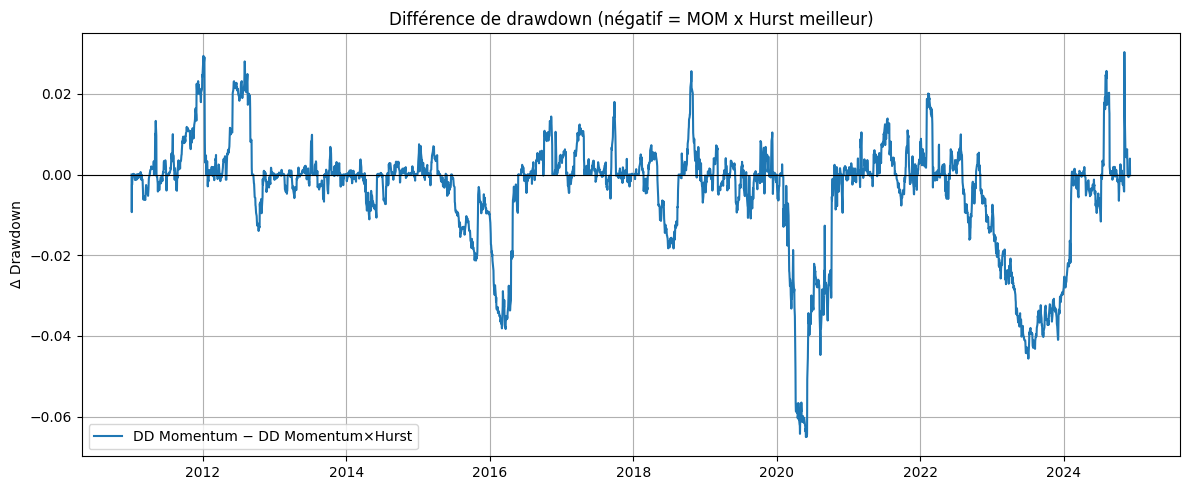

In [16]:
#Ecart de Drawdown

def drawdown(curve):
    return curve / curve.cummax() - 1

dd_mom = drawdown(curve_ind_mom)
dd_h   = drawdown(curve_ind_h)

dd_diff = dd_mom - dd_h

plt.figure(figsize=(12,5))
plt.plot(dd_diff, label="DD Momentum − DD Momentum×Hurst")
plt.axhline(0, color="black", linewidth=0.8)

plt.title("Différence de drawdown (négatif = MOM x Hurst meilleur)")
plt.ylabel("Δ Drawdown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Calme (2013-2019)


,Ann.Return,Ann.Vol,Sharpe,MaxDD,TotalReturn
Strategy,,,,,
Industry MOM × Hurst (W=60),0.177421,0.138460,1.281389,-0.191665,2.130968
Industry Momentum (W=60),0.172988,0.136536,1.266976,-0.197000,2.049516
S&P 500,0.120109,0.128079,0.937772,-0.197782,1.209201



Crise COVID (2020H1)


,Ann.Return,Ann.Vol,Sharpe,MaxDD,TotalReturn
Strategy,,,,,
Industry MOM × Hurst (W=60),-0.113876,0.532683,-0.213779,-0.349396,-0.038115
S&P 500,-0.183209,0.550629,-0.332727,-0.339250,-0.062978
Industry Momentum (W=60),-0.319291,0.549768,-0.580775,-0.374069,-0.116292



Reprise (2020H2-2022)


,Ann.Return,Ann.Vol,Sharpe,MaxDD,TotalReturn
Strategy,,,,,
Industry Momentum (W=60),0.248767,0.196295,1.267312,-0.208795,0.742623
Industry MOM × Hurst (W=60),0.219946,0.194517,1.130728,-0.207223,0.643810
S&P 500,0.087123,0.189263,0.460329,-0.254251,0.232244


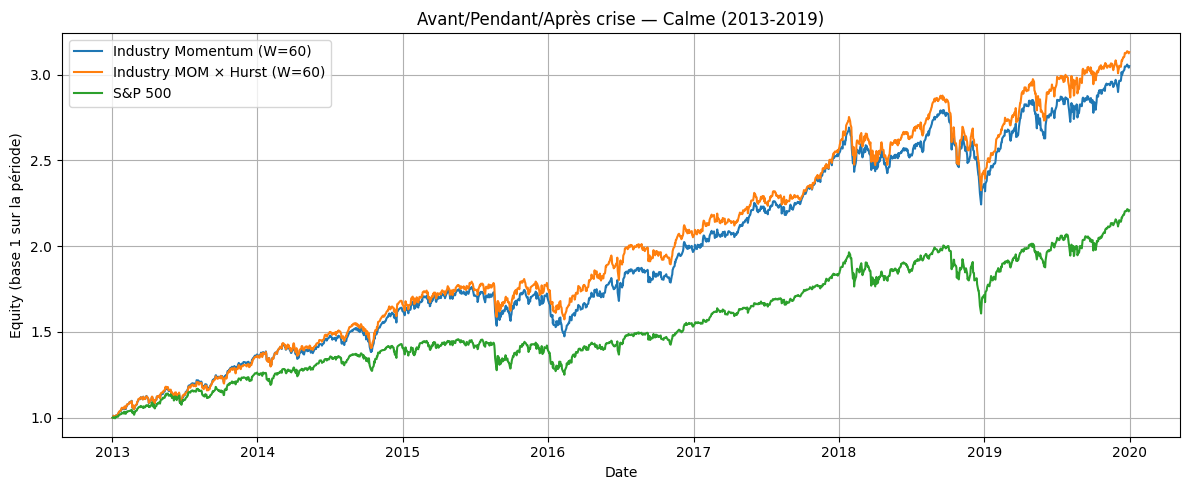

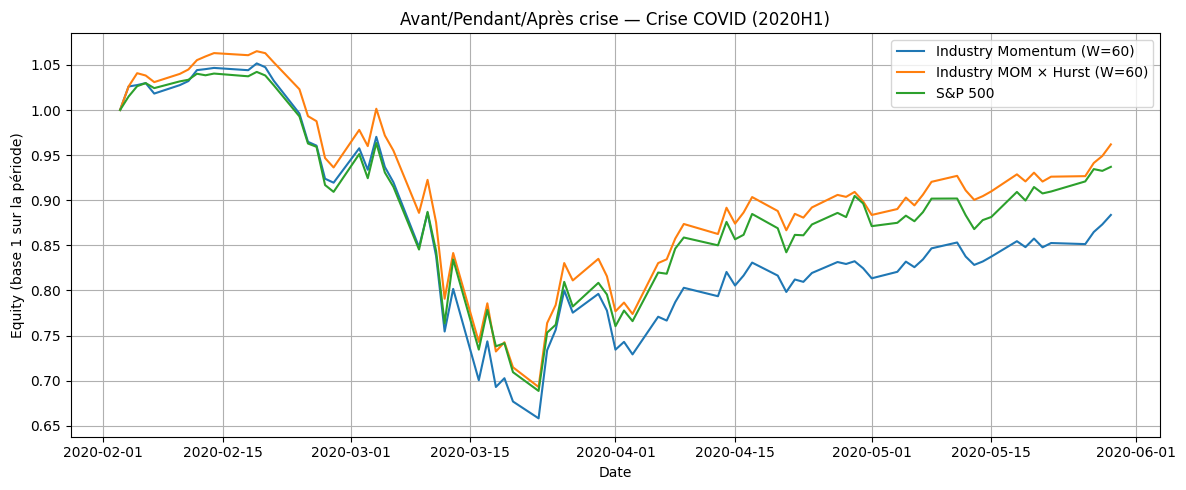

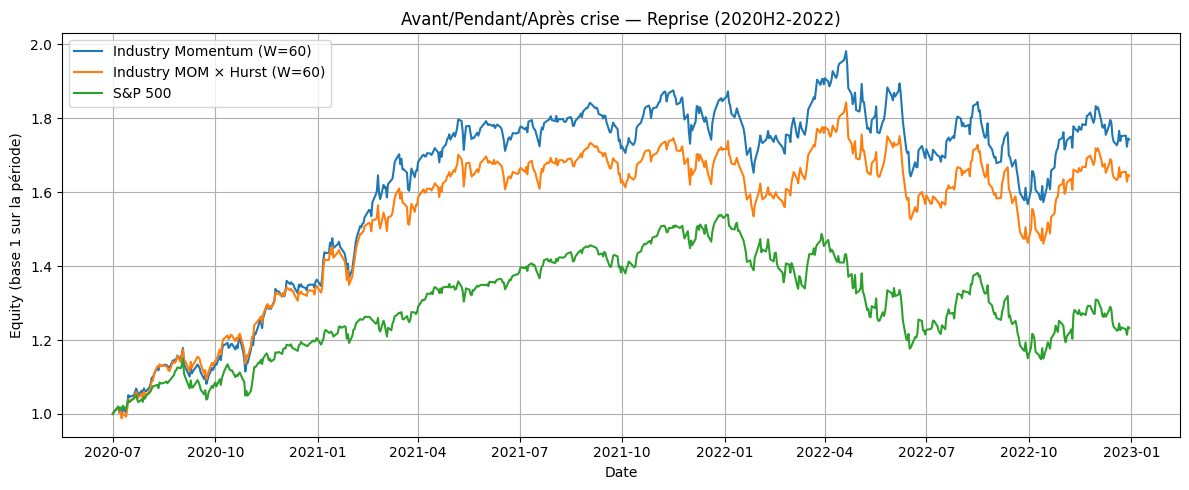

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# curve_ind_mom : Industry Momentum (W=60)
# curve_ind_h   : Industry Momentum × Hurst (W=60)
# bench_curve   : S&P 500


# 1) on défini lesrégimes

REGIMES = {
    "Calme (2013-2019)"      : ("2013-01-01", "2019-12-31"),
    "Crise COVID (2020H1)"   : ("2020-02-01", "2020-05-30"),
    "Reprise (2020H2-2022)"  : ("2020-07-01", "2022-12-31"),
}


# 2) Fonctions stats par period

def perf_stats_period(curve, start, end, periods_per_year=252):

    x = curve.loc[start:end].dropna()
    if len(x) < 10:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    r = x.pct_change().dropna()
    if len(r) < 5:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    ann_return = (x.iloc[-1] / x.iloc[0]) ** (periods_per_year / len(r)) - 1
    ann_vol = float(r.std() * np.sqrt(periods_per_year))
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    dd = x / x.cummax() - 1
    max_dd = float(dd.min())

    total_return = float(x.iloc[-1] / x.iloc[0] - 1)

    return float(ann_return), float(ann_vol), float(sharpe), float(max_dd), float(total_return)

def normalize_period(curve, start, end):
    x = curve.loc[start:end].dropna()
    if len(x) == 0:
        return x
    return x / x.iloc[0]


# 3) Table des stats par régime

curves_dict = {
    "Industry Momentum (W=60)": curve_ind_mom,
    "Industry MOM × Hurst (W=60)": curve_ind_h,
    "S&P 500": bench_curve,
}

rows = []
for regime_name, (start, end) in REGIMES.items():
    for strat_name, curve in curves_dict.items():
        ar, vol, sh, mdd, tot = perf_stats_period(curve, start, end)
        rows.append([regime_name, strat_name, ar, vol, sh, mdd, tot])

regime_stats = pd.DataFrame(
    rows,
    columns=["Regime", "Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "TotalReturn"]
)

# un etable de stat par régime
for regime_name in REGIMES.keys():
    print("\n" + "="*80)
    print(regime_name)
    display(
        regime_stats[regime_stats["Regime"] == regime_name]
        .set_index("Strategy")[["Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "TotalReturn"]]
        .sort_values("Sharpe", ascending=False)
    )


# 4) Graphes par régime en base 1

for regime_name, (start, end) in REGIMES.items():
    plt.figure(figsize=(12,5))

    for strat_name, curve in curves_dict.items():
        x = normalize_period(curve, start, end)
        if len(x) > 0:
            plt.plot(x, label=strat_name)

    plt.title(f"Avant/Pendant/Après crise — {regime_name}")
    plt.xlabel("Date")
    plt.ylabel("Equity (base 1 sur la période)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
best_by_regime = (
    regime_stats.dropna()
    .sort_values(["Regime", "Sharpe"], ascending=[True, False])
    .groupby("Regime")
    .head(1)[["Regime", "Strategy", "Sharpe", "Ann.Return", "MaxDD"]]
)
display(best_by_regime)


,Regime,Strategy,Sharpe,Ann.Return,MaxDD
1,Calme (2013-2019),Industry MOM × Hurst (W=60),1.281389,0.177421,-0.191665
4,Crise COVID (2020H1),Industry MOM × Hurst (W=60),-0.213779,-0.113876,-0.349396
6,Reprise (2020H2-2022),Industry Momentum (W=60),1.267312,0.248767,-0.208795


In [19]:
import numpy as np
import pandas as pd

#ajout alpha et beta

def perf_stats(curve, periods_per_year=252):
    if isinstance(curve, pd.DataFrame):
        curve = curve.iloc[:, 0]
    curve = curve.dropna()

    r = curve.pct_change().dropna()

    ann_return = (curve.iloc[-1] / curve.iloc[0])**(periods_per_year / len(r)) - 1
    ann_vol = float(r.std() * np.sqrt(periods_per_year))
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan

    dd = curve / curve.cummax() - 1
    max_dd = float(dd.min())

    return float(ann_return), float(ann_vol), float(sharpe), float(max_dd)

def alpha_beta(curve_strat, curve_bench, periods_per_year=252):
    rs = curve_strat.pct_change().dropna()
    rb = curve_bench.pct_change().dropna()

    idx = rs.index.intersection(rb.index)
    rs = rs.loc[idx]
    rb = rb.loc[idx]

    X = rb.values
    Y = rs.values

    beta = np.cov(Y, X)[0, 1] / np.var(X)
    alpha_daily = Y.mean() - beta * X.mean()
    alpha_ann = (1 + alpha_daily)**periods_per_year - 1

    return float(alpha_ann), float(beta)

rows = []

for name, curve in [
    ("Industry Momentum (W=60)", curve_ind_mom),
    ("Industry MOM × Hurst (W=60)", curve_ind_h),
    ("S&P 500", curve_sp),
]:
    ar, vol, sh, mdd = perf_stats(curve)

    if name != "S&P 500":
        a, b = alpha_beta(curve, curve_sp)
    else:
        a, b = np.nan, 1.0

    rows.append([name, ar, vol, sh, mdd, a, b])

stats_ab = pd.DataFrame(
    rows,
    columns=["Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "Alpha (ann.)", "Beta"]
).set_index("Strategy")

display(stats_ab)


,Ann.Return,Ann.Vol,Sharpe,MaxDD,Alpha (ann.),Beta
Strategy,,,,,,
Industry Momentum (W=60),0.179716,0.183749,0.978051,-0.375823,0.059910,0.977966
Industry MOM × Hurst (W=60),0.167255,0.179342,0.932602,-0.349396,0.050494,0.957592
S&P 500,0.116600,0.172330,0.676613,-0.339250,NaN,1.000000


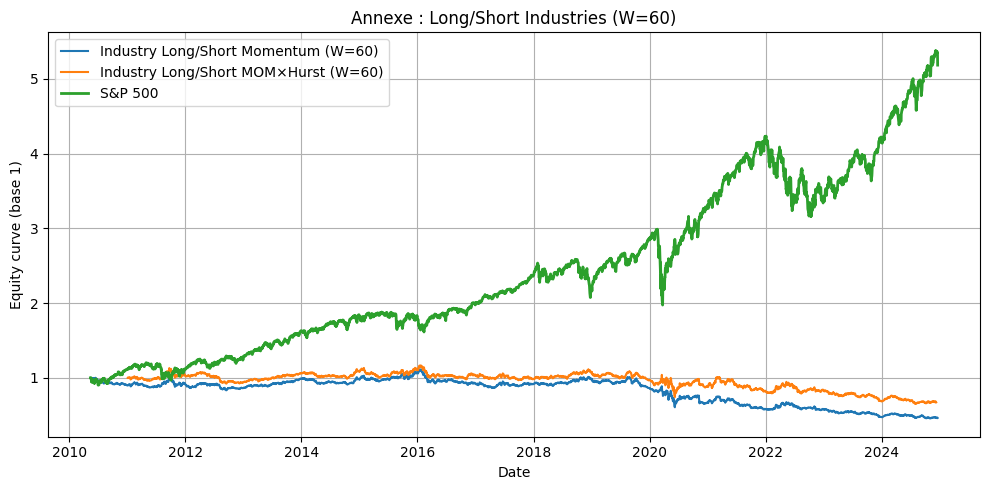

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Test du Long Short qui fonctionne aps

def backtest_long_short(score_df, returns_df, q=0.3, reb_step=21):
    rebalance_dates = score_df.dropna(how="all").index[::reb_step]
    daily_list = []

    for i in range(len(rebalance_dates) - 1):
        ds = rebalance_dates[i]
        de = rebalance_dates[i + 1]

        scores = score_df.loc[ds].dropna()
        if len(scores) == 0:
            continue

        n = max(1, int(len(scores) * q))
        ranked = scores.sort_values(ascending=False)

        longs = ranked.head(n).index.tolist()
        shorts = ranked.tail(n).index.tolist()

        mask = (returns_df.index > ds) & (returns_df.index <= de)
        period = returns_df.loc[mask]

        if len(longs) > 0:
            r_long = period[longs].mean(axis=1)
        else:
            r_long = 0

        if len(shorts) > 0:
            r_short = period[shorts].mean(axis=1)
        else:
            r_short = 0

        r_ls = r_long - r_short
        daily_list.append(r_ls)

    daily = pd.concat(daily_list).sort_index()
    curve = (1 + daily).cumprod()
    curve.iloc[0] = 1.0
    return curve



# Calcul des courbes Long/Short

curve_ls_mom = backtest_long_short(ind_mom, ind_returns, q=0.3, reb_step=21)
curve_ls_h   = backtest_long_short(ind_score, ind_returns, q=0.3, reb_step=21)


bench_ls = bench_curve.reindex(curve_ls_mom.index).ffill()


# Plot des courbes

plt.figure(figsize=(10, 5))
plt.plot(curve_ls_mom, label="Industry Long/Short Momentum (W=60)")
plt.plot(curve_ls_h, label="Industry Long/Short MOM×Hurst (W=60)")
plt.plot(bench_ls, label="S&P 500", linewidth=2)

plt.title("Annexe : Long/Short Industries (W=60)")
plt.xlabel("Date")
plt.ylabel("Equity curve (base 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/nl/rvjdvfvx3r54vk7xs88t0gk00000gn/T/ipykernel_6884/3108801378.py:9: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return index_df.shift(skip).pct_change(periods=W - skip)


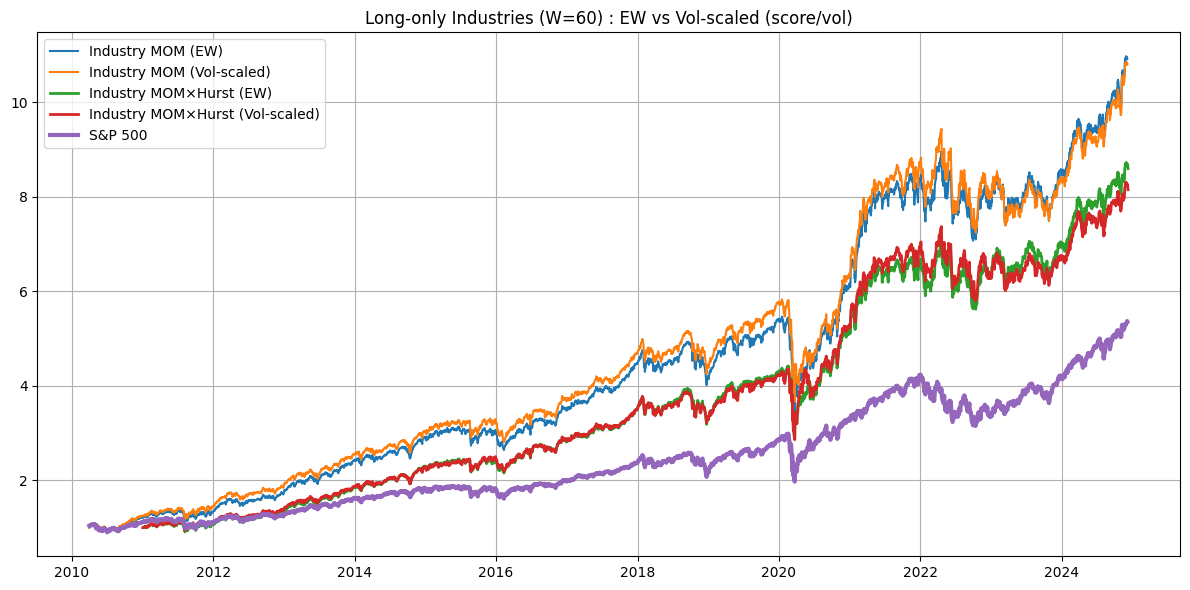

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# on divise par la vol

def momentum_with_skip(index_df, W, skip=0):
    if skip > 0:
        return index_df.shift(skip).pct_change(periods=W - skip)
    return index_df.pct_change(periods=W)


# 1) Backtest long-only avec poids (EW ou vol-scaled)

def backtest_long_only_weighted(score_df, returns_df, vol_df=None, q=0.3, reb_step=21, eps=1e-12):

    rebalance_dates = score_df.dropna(how="all").index[::reb_step]
    daily_list = []

    for i in range(len(rebalance_dates) - 1):
        ds = rebalance_dates[i]
        de = rebalance_dates[i + 1]

        scores = score_df.loc[ds].dropna()
        if len(scores) == 0:
            continue

        n = max(1, int(len(scores) * q))
        longs = scores.sort_values(ascending=False).head(n).index.tolist()

        mask = (returns_df.index > ds) & (returns_df.index <= de)
        period = returns_df.loc[mask, longs]
        if period.empty:
            continue

        # poids
        if vol_df is None:
            w = pd.Series(1.0 / len(longs), index=longs)
        else:
            vol_row = vol_df.loc[ds, longs].replace(0, np.nan)
            # score/vol (vol scaling)
            raw = scores.loc[longs] / (vol_row + eps)
            raw = raw.replace([np.inf, -np.inf], np.nan).dropna()

            if len(raw) == 0:
                continue

            # long-only => poids positifs
            raw = raw.clip(lower=0)
            if raw.sum() <= 0:
                continue

            w = raw / raw.sum()

            # garde seulement les colonnes dispo
            period = period[raw.index]

        port_ret = period.mul(w, axis=1).sum(axis=1)
        daily_list.append(port_ret)

    daily = pd.concat(daily_list).sort_index()
    curve = (1 + daily).cumprod()
    curve.iloc[0] = 1.0
    return curve, daily


# 2) Construire MOM & MOM×Hurst + volatilité rolling

W_focus = 60
skip = 10

# Momentum
ind_mom = momentum_with_skip(ind_index, W=W_focus, skip=skip)

# MOM×Hurst
hurst_adj_ind = (hurst_ind - 0.5).clip(lower=0)
ind_score = ind_mom * hurst_adj_ind

# Vol rolling (60j) sur les rendements industries
vol_window = 60
ind_vol = ind_returns.rolling(vol_window).std()


# 3) Backtests : EW vs vol-scaled

curve_mom_EW, daily_mom_EW = backtest_long_only_weighted(ind_mom, ind_returns, vol_df=None, q=quantile, reb_step=reb_step)
curve_mom_VS, daily_mom_VS = backtest_long_only_weighted(ind_mom, ind_returns, vol_df=ind_vol, q=quantile, reb_step=reb_step)

curve_h_EW, daily_h_EW = backtest_long_only_weighted(ind_score, ind_returns, vol_df=None, q=quantile, reb_step=reb_step)
curve_h_VS, daily_h_VS = backtest_long_only_weighted(ind_score, ind_returns, vol_df=ind_vol, q=quantile, reb_step=reb_step)

# Align benchmark
bench_aligned = bench_curve.reindex(curve_mom_EW.index).ffill()


# 4) Plot : comparaison

plt.figure(figsize=(12,6))
plt.plot(curve_mom_EW, label="Industry MOM (EW)")
plt.plot(curve_mom_VS, label="Industry MOM (Vol-scaled)")

plt.plot(curve_h_EW, label="Industry MOM×Hurst (EW)", linewidth=2)
plt.plot(curve_h_VS, label="Industry MOM×Hurst (Vol-scaled)", linewidth=2)

plt.plot(bench_aligned, label="S&P 500", linewidth=3)

plt.title("Long-only Industries (W=60) : EW vs Vol-scaled (score/vol)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
rows = []

for name, curve in [
    ("MOM (EW)", curve_mom_EW),
    ("MOM (Vol-scaled)", curve_mom_VS),
    ("MOM×Hurst (EW)", curve_h_EW),
    ("MOM×Hurst (Vol-scaled)", curve_h_VS),
    ("S&P 500", bench_aligned),
]:
    ar, vol, sh, mdd = perf_stats(curve)

    if name != "S&P 500":
        a, b = alpha_beta(curve, bench_aligned)
    else:
        a, b = np.nan, 1.0

    rows.append([name, ar, vol, sh, mdd, a, b])

stats_volscale = pd.DataFrame(
    rows,
    columns=["Strategy", "Ann.Return", "Ann.Vol", "Sharpe", "MaxDD", "Alpha (ann.)", "Beta"]
).set_index("Strategy")

display(stats_volscale.sort_values("Sharpe", ascending=False))


,Ann.Return,Ann.Vol,Sharpe,MaxDD,Alpha (ann.),Beta
Strategy,,,,,,
MOM (EW),0.177109,0.182286,0.971603,-0.375823,0.058730,0.967198
MOM (Vol-scaled),0.176265,0.181451,0.971421,-0.369402,0.063566,0.924414
MOM×Hurst (EW),0.167255,0.179342,0.932602,-0.349396,0.051026,0.957506
MOM×Hurst (Vol-scaled),0.162786,0.177923,0.914923,-0.343833,0.054084,0.903858
S&P 500,0.118366,0.172885,0.684650,-0.339250,NaN,1.000000


=== Walk-forward params (head) ===
  train_start  train_end test_start   test_end  best_W  best_reb  \
0  2010-01-04 2013-01-04 2013-01-04 2013-07-04      60        10   
1  2010-07-04 2013-07-04 2013-07-04 2014-01-04      60        42   
2  2011-01-04 2014-01-04 2014-01-04 2014-07-04      60        21   
3  2011-07-04 2014-07-04 2014-07-04 2015-01-04      60        21   
4  2012-01-04 2015-01-04 2015-01-04 2015-07-04     120        42   

   train_sharpe  test_sharpe  test_days  
0      0.752989     1.421943        125  
1      1.072064     2.871785        127  
2      1.275049     0.834564        125  
3      1.769938     1.347231        126  
4      1.809617     1.267519        125  

=== OOS Sharpe global ===
0.859


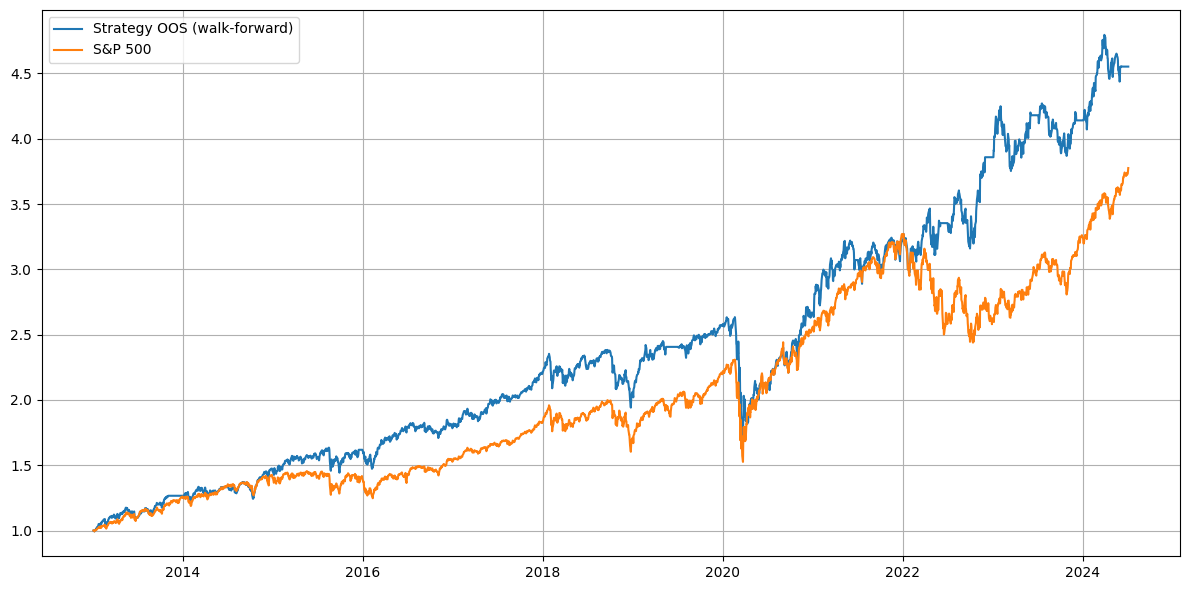

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def momentum_with_skip(index_df, W, skip=0):
    if skip > 0:
        # pas de fill implicite
        return index_df.shift(skip).pct_change(periods=W - skip, fill_method=None)
    return index_df.pct_change(periods=W, fill_method=None)



def backtest_long_only_weighted(score_df, returns_df, vol_df=None, q=0.3, reb_step=21, eps=1e-12):

    # Dates où on peut rebalance
    valid_idx = score_df.dropna(how="all").index
    if len(valid_idx) == 0:
        daily = pd.Series(0.0, index=returns_df.index)
        curve = (1 + daily).cumprod()
        curve.iloc[0] = 1.0
        return curve, daily

    rebalance_dates = valid_idx[::reb_step]
    daily_list = []

    for i in range(len(rebalance_dates) - 1):
        ds = rebalance_dates[i]
        de = rebalance_dates[i + 1]

        scores = score_df.loc[ds].dropna()
        if len(scores) == 0:
            continue

        n = max(1, int(len(scores) * q))
        longs = scores.sort_values(ascending=False).head(n).index.tolist()

        mask = (returns_df.index > ds) & (returns_df.index <= de)
        period = returns_df.loc[mask, longs]
        if period.empty:
            continue

        # poids
        if vol_df is None:
            w = pd.Series(1.0 / len(longs), index=longs)
        else:
            # vol scaling score/vol
            vol_row = vol_df.loc[ds, longs].replace(0, np.nan)

            raw = scores.loc[longs] / (vol_row + eps)
            raw = raw.replace([np.inf, -np.inf], np.nan).dropna()

            if len(raw) == 0:
                continue

            raw = raw.clip(lower=0)
            if raw.sum() <= 0:
                continue

            w = raw / raw.sum()
            period = period[raw.index]

        port_ret = period.mul(w, axis=1).sum(axis=1)
        daily_list.append(port_ret)


    if len(daily_list) == 0:
        daily = pd.Series(0.0, index=returns_df.index)
    else:
        daily = pd.concat(daily_list).sort_index()
     
        daily = daily.reindex(returns_df.index).fillna(0.0)

    curve = (1 + daily).cumprod()
    if len(curve) > 0:
        curve.iloc[0] = 1.0
    return curve, daily



def sharpe_ann(daily_ret: pd.Series, ann=252, rf=0.0):
    r = daily_ret.dropna()
    if len(r) < 30:
        return np.nan
    ex = r - rf/ann
    vol = ex.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return np.sqrt(ann) * ex.mean() / vol



def run_combo_oos(train_dates, test_dates, W_focus, reb_step,
                 skip=10, vol_window=60, use_vol_scaled=True):

    full_dates = train_dates.union(test_dates)

    index_full   = ind_index.loc[full_dates]
    returns_full = ind_returns.loc[full_dates]
    hurst_full   = hurst_ind.loc[full_dates]

    # Momentum + Score
    mom = momentum_with_skip(index_full, W=W_focus, skip=skip)
    hurst_adj = (hurst_full - 0.5).clip(lower=0)
    score = mom * hurst_adj

    vol_df = returns_full.rolling(vol_window).std() if use_vol_scaled else None


    score = score.shift(1)
    if vol_df is not None:
        vol_df = vol_df.shift(1)


    curve_full, daily_full = backtest_long_only_weighted(
        score_df=score,
        returns_df=returns_full,
        vol_df=vol_df,
        q=quantile,
        reb_step=reb_step
    )


    daily_test = daily_full.reindex(test_dates).fillna(0.0)
    curve_test = (1 + daily_test).cumprod()
    if len(curve_test) > 0:
        curve_test.iloc[0] = 1.0

    return curve_test, daily_test



W_GRID = [20, 40, 60, 90, 120]
REBAL_GRID = [5, 10, 21, 42]
SKIP = 10
VOL_WINDOW = 60
USE_VOL_SCALED = True

train_years = 3
test_months = 6

dates = ind_index.index.intersection(ind_returns.index).intersection(hurst_ind.index)
dates = dates.sort_values()

oos_daily_list = []
selection_log = []

start = dates.min()

while True:
    train_start = start
    train_end   = train_start + pd.DateOffset(years=train_years)
    test_end    = train_end + pd.DateOffset(months=test_months)

    if test_end > dates.max():
        break

    train_dates = dates[(dates >= train_start) & (dates < train_end)]
    test_dates  = dates[(dates >= train_end) & (dates < test_end)]

    if len(train_dates) < 200 or len(test_dates) < 20:
        start = start + pd.DateOffset(months=test_months)
        continue


    best = {"sharpe": -np.inf, "W": None, "reb": None}

    for W in W_GRID:
        if W <= SKIP:   
            continue

        for reb in REBAL_GRID:

            train_index = ind_index.loc[train_dates]
            train_ret   = ind_returns.loc[train_dates]
            train_hurst = hurst_ind.loc[train_dates]

            mom = momentum_with_skip(train_index, W=W, skip=SKIP)
            hurst_adj = (train_hurst - 0.5).clip(lower=0)
            score = (mom * hurst_adj).shift(1)

            vol_df = train_ret.rolling(VOL_WINDOW).std().shift(1) if USE_VOL_SCALED else None

            _, daily_train = backtest_long_only_weighted(
                score_df=score,
                returns_df=train_ret,
                vol_df=vol_df,
                q=quantile,
                reb_step=reb
            )

            sh = sharpe_ann(daily_train)

            if np.isfinite(sh) and sh > best["sharpe"]:
                best.update({"sharpe": sh, "W": W, "reb": reb})


    curve_test, daily_test = run_combo_oos(
        train_dates=train_dates,
        test_dates=test_dates,
        W_focus=best["W"],
        reb_step=best["reb"],
        skip=SKIP,
        vol_window=VOL_WINDOW,
        use_vol_scaled=USE_VOL_SCALED
    )

    oos_daily_list.append(daily_test)

    selection_log.append({
        "train_start": train_start,
        "train_end": train_end,
        "test_start": train_end,
        "test_end": test_end,
        "best_W": best["W"],
        "best_reb": best["reb"],
        "train_sharpe": best["sharpe"],
        "test_sharpe": sharpe_ann(daily_test),
        "test_days": int(daily_test.shape[0])
    })

    start = start + pd.DateOffset(months=test_months)


oos_daily = pd.concat(oos_daily_list).sort_index()
oos_curve = (1 + oos_daily).cumprod()
if len(oos_curve) > 0:
    oos_curve.iloc[0] = 1.0

bench_oos = bench_curve.reindex(oos_curve.index).ffill()
bench_oos = bench_oos / bench_oos.iloc[0]  # FIX benchmark à 1

log_df = pd.DataFrame(selection_log)
print("=== Walk-forward params (head) ===")
print(log_df.head())
print("\n=== OOS Sharpe global ===")
print(f"{sharpe_ann(oos_daily):.3f}")

plt.figure(figsize=(12,6))
plt.plot(oos_curve, label="Strategy OOS (walk-forward)")
plt.plot(bench_oos, label="S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


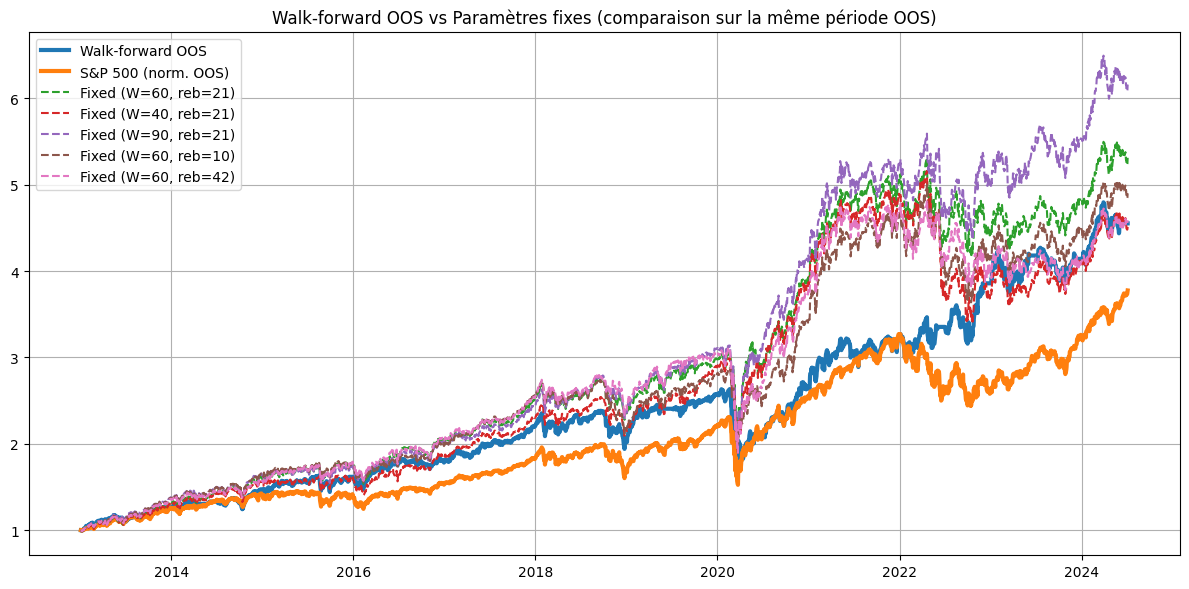

In [26]:


def run_fixed_params_curve(W_focus, reb_step, skip=10, vol_window=60, use_vol_scaled=True):
    """
    Backtest sur TOUT l'historique avec paramètres fixes.
    On calcule les signaux sur toute la période (comme en vrai), puis on backtest.
    """
    idx = ind_index.index.intersection(ind_returns.index).intersection(hurst_ind.index).sort_values()

    index_full   = ind_index.loc[idx]
    returns_full = ind_returns.loc[idx]
    hurst_full   = hurst_ind.loc[idx]

    mom = momentum_with_skip(index_full, W=W_focus, skip=skip)
    hurst_adj = (hurst_full - 0.5).clip(lower=0)
    score = mom * hurst_adj

    vol_df = returns_full.rolling(vol_window).std() if use_vol_scaled else None


    score = score.shift(1)
    if vol_df is not None:
        vol_df = vol_df.shift(1)

    curve, daily = backtest_long_only_weighted(
        score_df=score,
        returns_df=returns_full,
        vol_df=vol_df,
        q=quantile,
        reb_step=reb_step
    )

    daily = daily.reindex(returns_full.index).fillna(0.0)
    curve = (1 + daily).cumprod()
    if len(curve) > 0:
        curve.iloc[0] = 1.0

    return curve, daily


fixed_param_list = [
    (60, 21),   
    (40, 21),
    (90, 21),
    (60, 10),
    (60, 42),
]


plot_index = oos_curve.index

fixed_curves = {}
for W_fix, reb_fix in fixed_param_list:
    curve_full, _ = run_fixed_params_curve(
        W_focus=W_fix,
        reb_step=reb_fix,
        skip=SKIP,
        vol_window=VOL_WINDOW,
        use_vol_scaled=USE_VOL_SCALED
    )


    curve_oos = curve_full.reindex(plot_index).ffill()


    curve_oos = curve_oos / curve_oos.iloc[0]
    fixed_curves[(W_fix, reb_fix)] = curve_oos



plt.figure(figsize=(12, 6))

plt.plot(oos_curve, label="Walk-forward OOS", linewidth=3)
plt.plot(bench_oos, label="S&P 500 (norm. OOS)", linewidth=3)

for (W_fix, reb_fix), c in fixed_curves.items():
    plt.plot(c, label=f"Fixed (W={W_fix}, reb={reb_fix})", linestyle="--")

plt.title("Walk-forward OOS vs Paramètres fixes (comparaison sur la même période OOS)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
